In [ ]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import defaultdict
from skopt import gp_minimize
from skopt.space import Integer, Real

warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
base = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Base.csv')
base_copy = base.copy()

var1 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant I.csv')
var1_copy = var1.copy()

var2 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant II.csv')
var2_copy = var2.copy()

var3 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant III.csv')
var3_copy = var3.copy()

var4 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant IV.csv')
var4_copy = var4.copy()

var5 = pd.read_csv('D:/Users/tonyn/Desktop/da_sci_4th/datathon/DATA/Variant V.csv')
var5_copy = var5.copy()

In [ ]:
### EDA dataset preprocessing ###
def EDA_dataset(df):
    drop_col = ['payment_type', 'employment_status', 'prev_address_months_count', 'intended_balcon_amount', 'housing_status', 'days_since_request']
    df.drop(columns = drop_col, inplace = True)

    df = df[df['current_address_months_count'] >= 0]

    df['bank_months_count'].replace({-1: 0}, inplace = True)

    df = df[df['session_length_in_minutes'] >= 0]

    df['proposed_credit_limit'] = df['proposed_credit_limit'].astype(int)


    return df

In [ ]:
base_copy = EDA_dataset(base_copy)
var1_copy = EDA_dataset(var1_copy)
var2_copy = EDA_dataset(var2_copy)
var3_copy = EDA_dataset(var3_copy)
var4_copy = EDA_dataset(var4_copy)
var5_copy = EDA_dataset(var5_copy)

In [ ]:
### One-hot encoding for categorical variables####
def one_hot(df):
    object_cols = ['source', 'device_os']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    return df

In [ ]:
base_copy = one_hot(base_copy)
var1_copy = one_hot(var1_copy)  
var2_copy = one_hot(var2_copy)
var3_copy = one_hot(var3_copy)
var4_copy = one_hot(var4_copy)
var5_copy = one_hot(var5_copy)

In [ ]:
###100만개 데이터 중 10만개씩 sampling###
def sample_data_stratified(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)

    X = df.drop(columns=['group'])
    y = df['group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [ ]:
base_sam, X_test, y_train, y_test = sample_data_stratified(base_copy)
var1_sam, X_test, y_train, y_test = sample_data_stratified(var1_copy)
var2_sam, X_test, y_train, y_test = sample_data_stratified(var2_copy)
var3_sam, X_test, y_train, y_test = sample_data_stratified(var3_copy)

In [ ]:
###100만개 데이터 중 10만개씩 sampling###
def sample_data_stratified_2(df):
    df.loc[(df['month'] <= 6) & (df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['month'] <= 6) & (df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['month'] <= 6) & (df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['month'] <= 6) & (df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df.loc[(df['month'] > 6) & (df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 4
    df.loc[(df['month'] > 6) & (df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 5
    df.loc[(df['month'] > 6) & (df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 6
    df.loc[(df['month'] > 6) & (df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 7
    df['group'] = df['group'].astype(int)

    X = df.drop(columns=['group'])
    y = df['group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [ ]:
var4_sam, X_test, y_train, y_test = sample_data_stratified_2(var4_copy)
var5_sam, X_test, y_train, y_test = sample_data_stratified_2(var5_copy)

In [ ]:
##### Correlation Matrix Heatmap ###
df = [base_copy, var1_copy, var2_copy, var3_copy, var4_copy, var5_copy]
for df in df:
    correlation_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(35, 35))
    sns.heatmap(
        correlation_matrix,  
        annot=True,          
        cmap='coolwarm',     
        fmt=".2f",          
        linewidths=.5,      
        cbar=True           
    )
    plt.title('Correlation Matrix Heatmap')
    plt.show()

# %%
# #### Distribution of All Columns ###
num_cols = len(base_copy.columns)
x = 4
y = (num_cols + x - 1) // x 
plt.figure(figsize=(x * 5, y * 4))
for i, col in enumerate(base_copy.columns):
    plt.subplot(y, x, i + 1)

    if base_copy[col].nunique() < 5 and base_copy[col].dtype == 'int64':
            sns.countplot(x=col, data=base_copy)
            plt.xlabel(col, fontsize=10)
            plt.ylabel('Count', fontsize=10)

    else:
        sns.histplot(base_copy[col], kde=True, bins=30)
        plt.xlabel(col, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.suptitle('All Columns Distribution', y=1.02, fontsize=18) 
plt.show()

In [ ]:
### data splitting for modelingng
def split_train_test(df):
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 0), 'group'] = 0
    df.loc[(df['customer_age'] < 50) & (df['fraud_bool'] == 1), 'group'] = 1
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 0), 'group'] = 2
    df.loc[(df['customer_age'] >= 50) & (df['fraud_bool'] == 1), 'group'] = 3
    df['group'] = df['group'].astype(int)

    X = df.drop(columns=['fraud_bool', 'group'])
    y = df['group']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [ ]:
x_train_base, x_test_base, y_train_base, y_test_base = split_train_test(base_sam)
x_train_var1, x_test_var1, y_train_var1, y_test_var1 = split_train_test(var1_sam)
x_train_var2, x_test_var2, y_train_var2, y_test_var2 = split_train_test(var2_sam)
x_train_var3, x_test_var3, y_train_var3, y_test_var3 = split_train_test(var3_sam)

In [ ]:
def split_train_test_2(df):
    X_train = df[df['month'] <= 6].drop(columns=['fraud_bool', 'group'])
    y_train = df[df['month'] <= 6]['group']
    X_test = df[df['month'] > 6].drop(columns=['fraud_bool', 'group'])
    y_test = df[df['month'] > 6]['group']
    
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)
    
    return X_train, X_test, y_train, y_test

In [ ]:
x_train_var4, x_test_var4, y_train_var4, y_test_var4 = split_train_test_2(var4_sam)
x_train_var5, x_test_var5, y_train_var5, y_test_var5 = split_train_test_2(var5_sam)

In [ ]:
def k_fold_training_smote(model_instance, X_train, y_train):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for fold, (train_index, val_index) in enumerate(k_fold.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)), # SMOTE 인스턴스
            ('classifier', model_instance)      # 모델 인스턴스 (하이퍼파라미터가 적용된)
        ])
        # 모델 학습
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        auc_score = roc_auc_score(y_val_fold, y_val_proba)
        auc_scores.append(auc_score)

        # 마지막 폴드의 결과 저장
        if fold == k_fold.get_n_splits() - 1:
            last_fold_y_val = y_val_fold
            last_fold_y_proba = y_val_proba
            last_trained_pipeline = pipeline # 마지막 학습된 파이프라인 저장

    return auc_scores, last_fold_y_val, last_fold_y_proba, last_trained_pipeline

In [ ]:
#%% LightGBM 베이지안 최적화를 위한 하이퍼파라미터 공간 정의

lgb_space = [
Integer(100, 1000, name='n_estimators'),              # 부스팅 라운드 수
Real(0.01, 0.3, name='learning_rate', prior='log-uniform'),  # 학습률
Integer(20, 300, name='num_leaves'),                  # 리프 노드의 최대 개수
Integer(3, 15, name='max_depth'),                     # 트리의 최대 깊이
Real(0.5, 1.0, name='feature_fraction'),             # 각 트리에서 사용할 피처 비율
Real(0.5, 1.0, name='bagging_fraction'),             # 각 트리에서 사용할 데이터 비율
Integer(1, 10, name='bagging_freq'),                  # 배깅 빈도
Real(1e-9, 10.0, name='lambda_l1', prior='log-uniform'),    # L1 정규화
Real(1e-9, 10.0, name='lambda_l2', prior='log-uniform'),    # L2 정규화
Integer(5, 100, name='min_child_samples')             # 리프 노드의 최소 샘플 수
]

In [ ]:
#%%

# 하이퍼파라미터 이름
param_names = [
        "n_estimators",
        "learning_rate", 
        "num_leaves",
        "max_depth",
        "feature_fraction",
        "bagging_fraction",
        "bagging_freq",
        "lambda_l1",
        "lambda_l2",
        "min_child_samples"
    ]
datasets = {
    'base':  (x_train_base,  x_test_base,  y_train_base,  y_test_base),
    'var1':  (x_train_var1,  x_test_var1,  y_train_var1,  y_test_var1),
    'var2':  (x_train_var2,  x_test_var2,  y_train_var2,  y_test_var2),
    'var3':  (x_train_var3,  x_test_var3,  y_train_var3,  y_test_var3),
    'var4':  (x_train_var4,  x_test_var4,  y_train_var4,  y_test_var4),
    'var5':  (x_train_var5,  x_test_var5,  y_train_var5,  y_test_var5)
}

In [ ]:
results = {}
roc_data = defaultdict(dict)
pr_data = defaultdict(dict)
threshold_metrics_data = defaultdict(dict)

for name, (X_tr, X_te, y_tr, y_te) in datasets.items():
    print(f"\n==== Processing dataset: {name} ====")
    def objective(params):     
        param_dict = dict(zip(param_names, params))

        model = LGBMClassifier(
            **param_dict,
            random_state=42, 
            use_label_encoder=False, 
            eval_metric='auc',
            verbosity=-1
            )

        auc_scores, _, _, _ = k_fold_training_smote(model, X_tr, y_tr)
        return -np.mean(auc_scores)
    # 베이지안 최적화 수행
    res = gp_minimize(
        func=objective,
        dimensions=lgb_space,
        n_calls=50,
        n_random_starts=10,
        random_state=42,
        verbose=False
    )

    # N개의 상위 조합을 저장
    top_n = 15  # 원하는 개수
    all_params = pd.DataFrame(res.x_iters, columns=param_names)
    all_params['mean_cv_auc'] = -res.func_vals  # 최적화 목적이 -AUC였으므로 다시 양수로

    top_params = all_params.sort_values(by='mean_cv_auc', ascending=False).head(top_n)

    print(f"\n== 상위 {top_n}개 하이퍼파라미터 조합과 성능 ==")
    print(top_params)

    # 최적의 하이퍼파라미터 출력
    best_params = dict(zip(param_names, res.x))
    print("  최적의 하이퍼파라미터:", best_params)
    print(f"  CV AUC (평균): {-res.fun:.4f}")
    print(f"최적의 ROC AUC (K-Fold 검증 평균): {-res.fun:.4f}")


# SMOTE + LGBMClassifier Pipeline
    final_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', LGBMClassifier(
            **best_params,
            random_state=42,
            use_label_encoder=False,
            eval_metric='auc',
            verbosity=-1
        ))
    ])

    # 학습 데이터에 대해서만 SMOTE 적용하여 학습
    final_pipeline.fit(X_tr, y_tr)

    # 중요도 추출
    importance_dict = dict(zip(X_tr.columns, final_pipeline.named_steps['classifier'].feature_importances_))

    # 보기 좋게 정렬

    importance_df = pd.DataFrame({
        'feature': list(importance_dict.keys()),
        'importance': list(importance_dict.values())
    }).sort_values(by='importance', ascending=False)
    print(importance_df)

    # 매핑 딕셔너리
    fmap = {f"f{i}": col for i, col in enumerate(X_tr.columns)}

    # 변환
    importance_df['feature'] = importance_df['feature'].map(fmap)

    # 베이지안 최적화된 모델로 예측
    y_pred_label = final_pipeline.predict(X_te)
    y_pred_proba = final_pipeline.predict_proba(X_te)[:, 1]

    auc_score   = roc_auc_score(y_te, y_pred_proba)
    conf_mat    = confusion_matrix(y_te, y_pred_label)
    acc = accuracy_score(y_te, y_pred_label)
    prec = precision_score(y_te, y_pred_label)
    rec = recall_score(y_te, y_pred_label)
    fpr, tpr, thr = roc_curve(y_te, y_pred_proba)

    print(f"  테스트 AUC: {auc_score:.4f}, 정확도: {acc:.4f}, 정밀도: {prec:.4f}, 재현율: {rec:.4f}")

    # PR 곡선 좌표 저장
    precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_te, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr) # PR AUC 계산

    pr_data[name]['precision'] = precision_pr
    pr_data[name]['recall'] = recall_pr
    pr_data[name]['auc'] = pr_auc # PR AUC 저장

    
    # roc_curve의 thresholds를 사용하여 임계값 배열을 가져옵니다.
    # thresholds는 내림차순으로 정렬되어 있습니다.
    _, _, thresholds_for_metrics = roc_curve(y_te, y_pred_proba)

    # 고유한 임계값만 사용 (또는 일정 간격으로 샘플링 가능)
    unique_thresholds = np.unique(thresholds_for_metrics)
    # 임계값을 오름차순으로 정렬하여 그래프에서 0부터 1까지 순서대로 표시되게 합니다.
    unique_thresholds = np.sort(unique_thresholds)

    accuracies_at_threshold = []
    precisions_at_threshold = []
    recalls_at_threshold = []

    for threshold in unique_thresholds:
        y_pred_at_this_threshold = (y_pred_proba >= threshold).astype(int)
        accuracies_at_threshold.append(accuracy_score(y_te, y_pred_at_this_threshold))
        precisions_at_threshold.append(precision_score(y_te, y_pred_at_this_threshold, zero_division=0))
        recalls_at_threshold.append(recall_score(y_te, y_pred_at_this_threshold, zero_division=0))

    threshold_metrics_data[name] = {
        'thresholds': unique_thresholds, 
        'accuracy': accuracies_at_threshold, 
        'precision': precisions_at_threshold, 
        'recall': recalls_at_threshold
        }


    # 최적의 임계값 찾기 (예시: Youden's J statistic 최대화)
    # 'thresholds' 배열은 fpr과 tpr이 계산된 임계값들을 포함합니다.
    # thresholds[0]은 실제 사용된 가장 높은 임계값이며, thresholds[-1]은 가장 낮은 임계값입니다.
    # 일반적으로 thresholds 배열은 내림차순으로 정렬되어 있습니다.
    
    youden_j_scores = tpr - fpr
    youden_idx = np.argmax(youden_j_scores)
    threshold_youden = thr[youden_idx]
    fpr_youden = fpr[youden_idx]
    tpr_youden = tpr[youden_idx]
    print("\nClassification Report with Optimal Threshold (Youden's J):")
    print(f"최적 임계값 (Youden's J): {threshold_youden:.4f}")

    # 선택된 임계값으로 예측 수행
    y_pred_custom_threshold = (y_pred_proba >= threshold_youden).astype(int)
    print(classification_report(y_te, y_pred_custom_threshold))
    
    # 정확도 (Accuracy)
    accuracy = accuracy_score(y_te, y_pred_custom_threshold)

    # 정밀도 (Precision)
    precision = precision_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)

    # 재현율 (Recall)
    recall = recall_score(y_te, y_pred_custom_threshold, pos_label=1, zero_division=0)
    
    print("\n--- 최적 임계값 적용 시 성능 지표 ---")
    print(f"정확도 (Accuracy): {accuracy:.4f}")
    print(f"정밀도 (Precision): {precision:.4f}")
    print(f"재현율 (Recall): {recall:.4f}")


==== Processing dataset: base ====

== 상위 15개 하이퍼파라미터 조합과 성능 ==
    n_estimators  learning_rate  num_leaves  max_depth  feature_fraction  \
44           561       0.029270         300         15          0.500000   
43           423       0.033166         300         15          0.500000   
34           696       0.016541         300         15          0.500000   
16          1000       0.021855         172         15          0.500000   
33          1000       0.014746         300         15          0.500000   
39          1000       0.019495         300         13          0.500000   
45           812       0.038612         300         15          0.500000   
48           629       0.026139         300         15          0.716311   
28          1000       0.010000         234         15          0.500000   
37           788       0.025795          50         13          0.590617   
36          1000       0.012774         300         15          0.500000   
17          1000       

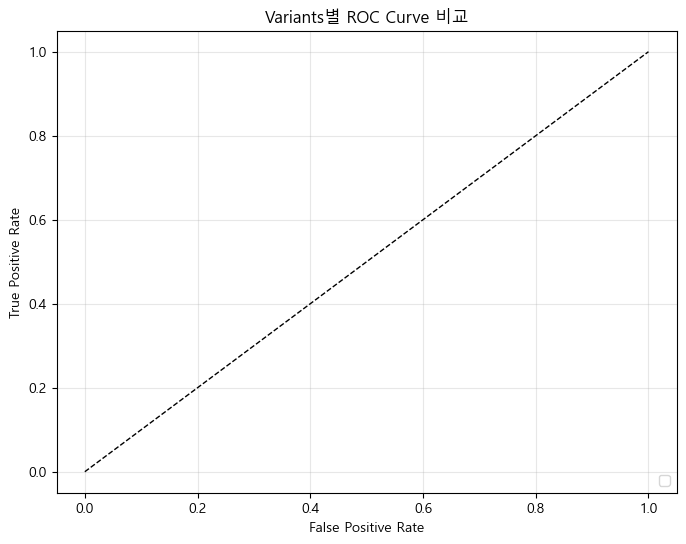

In [ ]:
#%% 

# [ROC Curve 통합 시각화]
plt.figure(figsize=(8, 6))
for name, res in roc_data.items():
    plt.plot(res['fpr'], res['tpr'], label=f"{name} (AUC={res['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Variants별 ROC Curve 비교")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

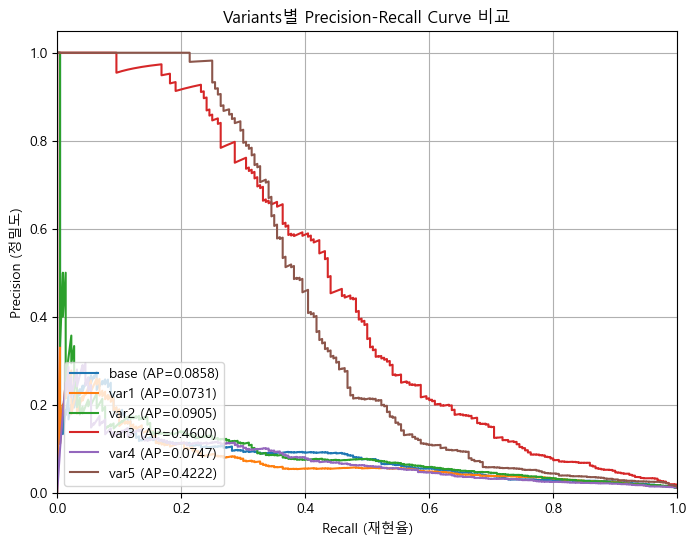

In [ ]:
#%%

# PR Curve 통합 시각화
plt.figure(figsize=(8, 6))
for name, res in pr_data.items():
    plt.plot(res['recall'], res['precision'], label=f"{name} (AP={res['auc']:.4f})") # AP = Average Precision, PR AUC와 동일

plt.xlabel("Recall (재현율)")
plt.ylabel("Precision (정밀도)")
plt.title("Variants별 Precision-Recall Curve 비교")
plt.legend(loc="lower left")
plt.grid(True)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [ ]:
# 모든 데이터셋의 Accuracy를 한 그래프에 비교
plt.figure(figsize=(12, 8))
for name, data in threshold_metrics_data.items():
    plt.plot(data['thresholds'], data['accuracy'], label=f'{name} Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Across Variants')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.show()

In [ ]:
# 모든 데이터셋의 Precision을 한 그래프에 비교
plt.figure(figsize=(12, 8))
for name, data in threshold_metrics_data.items():
    plt.plot(data['thresholds'], data['precision'], label=f'{name} Precision')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.title('Precision vs. Threshold Across Variants')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.show()

In [ ]:
# 모든 데이터셋의 Recall을 한 그래프에 비교
plt.figure(figsize=(12, 8))
for name, data in threshold_metrics_data.items():
    plt.plot(data['thresholds'], data['recall'], label=f'{name} Recall')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.title('Recall vs. Threshold Across Variants')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.show()